# Assignment 7: Classification with Support Vector Machines

# Total: 11 Marks 
## Instructions

* Complete the assignment

* Once the notebook is complete, restart your kernel and rerun your cells

* Submit this notebook to owl by the deadline



In [1]:
# You may need these
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, make_scorer, recall_score
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.utils.multiclass import unique_labels

%matplotlib inline

## Part A: 1 Mark

Read in the `emails.txt` dataset. Slice out the `time`, `winner` and `number` columns.

In [2]:
df = pd.read_csv("email.txt", delimiter="\t")

df = df.loc[:, ~df.columns.isin(["time", "number", "winner"])]

df.head()

,spam,to_multiple,from,cc,sent_email,image,attach,dollar,inherit,viagra,password,num_char,line_breaks,format,re_subj,exclaim_subj,urgent_subj,exclaim_mess
0,0,0,1,0,0,0,0,0,0,0,0,11.370,202,1,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,0,10.504,202,1,0,0,0,1
2,0,0,1,0,0,0,0,4,1,0,0,7.773,192,1,0,0,0,6
3,0,0,1,0,0,0,0,0,0,0,0,13.256,255,1,0,0,0,48
4,0,0,1,0,0,0,0,0,0,0,2,1.231,29,0,0,0,0,1


## Part B: 1 Mark

Split the data into train and test.  Hold out 50% of observations as the test set.  Pass `random_state=0` to `train_test_split` to ensure you get the same train and tests sets as the solution.

In [3]:
X = df.drop("spam", axis="columns").astype("float").values
y = df.spam.values

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.5, random_state=0)

## Part C: 1 Mark

Create a pipeline for your support vector machine.  You can start with a `kernel="rbf"` and `gamma="auto"`.

In [4]:
svc_pipe = Pipeline([("SVC", SVC(kernel="linear", gamma="auto"))])

## Part D: 3 Marks

Use your model to construct a confusion matrix by fitting and predicting on the training data (I've inlcluded a little helper function to make looking at the confusion matrix a little easier). Then answer the following using the confusion matrix (don't use sklearn's functions):

* What is your model's training accuracy?
* What is your model's training precision?
* What is your model's training recall?

Confusion matrix, without normalization
Model Acuracy is 0.91
Model Precision is 1.00
Model Recall is 0.02


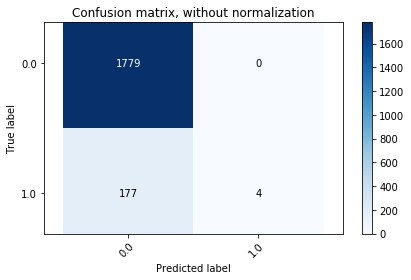

In [5]:
def plot_confusion_matrix(
    y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues
):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = "Normalized confusion matrix"
        else:
            title = "Confusion matrix, without normalization"

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")

    fig, ax = plt.subplots()
    ax.axis("equal")
    im = ax.imshow(cm, interpolation="nearest", cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        # ... and label them with the respective list entries
        xticklabels=classes,
        yticklabels=classes,
        title=title,
        ylabel="True label",
        xlabel="Predicted label",
    )

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j,
                i,
                format(cm[i, j], fmt),
                ha="center",
                va="center",
                color="white" if cm[i, j] > thresh else "black",
            )
    fig.tight_layout()
    return ax


svc_pipe.fit(Xtrain, ytrain)

ypreds = svc_pipe.predict(Xtrain)

plot_confusion_matrix(ytrain, ypreds, classes=np.array([0.0, 1.0]))
cm = confusion_matrix(ytrain, ypreds)

# Sum of diagonal entries divided by total sum
model_accuracy = np.diag(cm).sum() / cm.sum()

# Bottom right divided by sum of second column
model_precision = cm[1, 1] / np.sum(cm[:, 1])

# Bottom right divided by sum of second row
model_recall = cm[1, 1] / np.sum(cm[1, :])

print(f"Model Acuracy is {model_accuracy:.2f}")
print(f"Model Precision is {model_precision:.2f}")
print(f"Model Recall is {model_recall:.2f}")

## Part E:  1 Mark

Estimate your support vector machine's out of sample recall by using 5 fold cross validation.

In [6]:
cv_scores = cross_val_score(
    svc_pipe, Xtrain, ytrain, cv=5, scoring=make_scorer(recall_score)
)

print(f"Model CV recall is {cv_scores.mean():.2f}")

Model CV recall is 0.00


## Part F: 2 Marks

  Use sklearn's `GridSearchCV` to search over the kernel and gamma. Search over `kernel = ['rbf','sigmoid']` and `gamma = np.linspace(1e-5, 5)`.  Use recall as your metric for scoring.
  

`GridSearchCV` is a way to cross validate your models for a variety of parameters.  Read more about `GridSearchCV` [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

In [7]:
svc_pipe = Pipeline([("SVC", SVC())])


param_grid = {"SVC__kernel": ["sigmoid", "rbf"], "SVC__gamma": np.linspace(1e-5, 5)}

svc_gscv = GridSearchCV(
    svc_pipe,
    param_grid=param_grid,
    cv=5,
    scoring=make_scorer(recall_score),
    n_jobs=-1,
    iid=True,
)

svc_gscv.fit(Xtrain, ytrain)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('SVC',
                                        SVC(C=1.0, cache_size=200,
                                            class_weight=None, coef0=0.0,
                                            decision_function_shape='ovr',
                                            degree=3, gamma='auto_deprecated',
                                            kernel='rbf', max_iter=-1,
                                            probability=False,
                                            random_state=None, shrinking=True,
                                            tol=0.001, verbose=False))],
                                verbose=False),
             iid=True, n_jobs=-1,
             pa...
       3.26530959e+00, 3.36735020e+00, 3.46939082e+00, 3.57143143e+00,
       3.67347204e+00, 3.77551265e+00, 3.87755327e+00, 3.97959388e+00,
       4.08163449e+00, 4.1836751

## Part G: 1 Mark

What was the cross validated recall for your regularized model?  If you called your model grid search `svc_gscv` you can access the best model's score by performing `svc_gscv.best_score_`.


In [8]:
print(f"SVC model recall is {svc_gscv.best_score_:.2f}")

SVC model recall is 0.24


## Part H: 1 Mark

You can access the results of the cross validation `.cv_results_` method. If you called your estimator `svc_gcsv` then call `svc_gscv.cv_results_`.  This will return a dictionary.  You can turn it into a dataframe using `pandas.DataFrame` (this will make it easier to manipulate).  Learn more about `.cv_results_` [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

Plot how the mean test error changes as `gamma` changes.  Color the lines according to `kernel`. What do you see happening to the cross validated error as gamma increases?

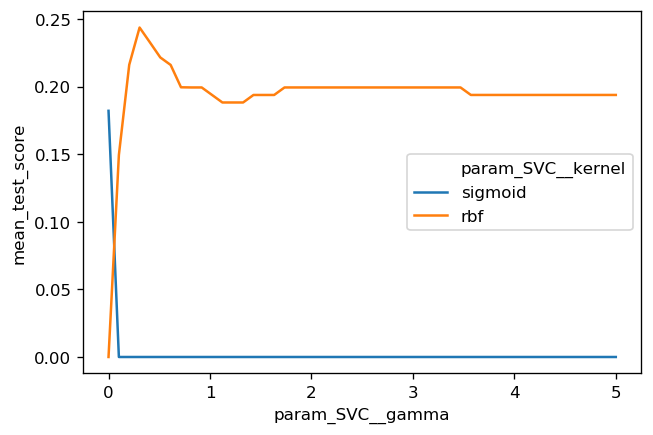

In [9]:
cv_results = pd.DataFrame(svc_gscv.cv_results_)

fig, ax = plt.subplots(dpi=120)

sns.lineplot(
    data=cv_results, x="param_SVC__gamma", y="mean_test_score", hue="param_SVC__kernel"
)